In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
# Define the file paths for the trajectory and structure
xtc_file = "vars/output_no_water.xtc"
gro_file = "vars/output_no_water.gro"

NUM_RES = 59
NUM_PROTEINS = 30
PROTEIN_LEN = 986
RNA_LEN = 707 # indicates the rna length
NUM_RNA = 30
NUM_RES_RNA = 22 #how many RESIDUES (nucleotide bases) in one rna
rna_start = NUM_PROTEINS * PROTEIN_LEN
RNA_START_INDEX = NUM_PROTEINS * PROTEIN_LEN

u = mda.Universe(gro_file, xtc_file)




/opt/conda/envs/gromacs/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.lib import distances
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor, as_completed

# calculates how many proteins are in contact with rna for each frame
def contacts_prot_rna_job_traj(gro_file, xtc_file, rna_index, radius=20):
    u = mda.Universe(gro_file, xtc_file)
    # Create an array with length equal to the number of frames
    is_in_contact = np.zeros(len(u.trajectory), dtype=int)
    
    # Select atoms for all proteins and specific RNA
    prot = u.select_atoms(f"bynum {1}:{NUM_PROTEINS * PROTEIN_LEN}") # assuming proteins go first
    rna = u.select_atoms(f"bynum {RNA_START_INDEX+1 + rna_index*RNA_LEN}:{RNA_START_INDEX+1 + (rna_index+1)*RNA_LEN}")

    for frame_index, ts in enumerate(u.trajectory):
        # Calculate centers-of-mass for each residue (protein and RNA)
        com_prot = prot.center_of_mass(compound='residues')
        com_rna = rna.center_of_mass(compound='residues')
        
        # Compute the pairwise distances
        dists = distances.distance_array(com_prot, com_rna, box=u.dimensions)
        for i in range(NUM_PROTEINS):
            prot_is_in_contact = False
            for j in range(NUM_RES):
                for k in range(NUM_RES_RNA):
                    if dists[i*NUM_RES+j][k] < radius:
                        prot_is_in_contact = True
                        break
                if prot_is_in_contact:
                    is_in_contact[frame_index] +=1
                    break
    return is_in_contact

def count_neighbor_proteins():
    # Assuming results for each RNA index should be stored separately
    rna_contact_results = np.zeros((NUM_RNA, len(u.trajectory)))  # 2D array: one row per RNA index

    with ProcessPoolExecutor(max_workers=32) as executor:
        # Map each future to its corresponding RNA index
        future_to_index = {
            executor.submit(contacts_prot_rna_job_traj, gro_file, xtc_file, i, radius=8): i
            for i in range(NUM_RNA)
        }
        
        for future in as_completed(future_to_index):
            index = future_to_index[future]
            result = future.result()
            #print(f"Future for RNA index {index} completed.")
            rna_contact_results[index, :] = result  # Store result in the corresponding row
    return rna_contact_results

# result = contacts_prot_rna_job_traj(gro_file, xtc_file, 5, radius=8)
# for res in result:
#     print(res)

def count_hbonds_rna(rna_index, average_all=False, HbondType ="GG"):
    rna_contact_results = count_neighbor_proteins()
    if (average_all):
        index_min = rna_start + 1
        index_max = rna_start + RNA_LEN*NUM_RNA
        protein_contacts = np.mean(rna_contact_results, axis=0)
    else:
        index_min = rna_start + rna_index * RNA_LEN + 1
        index_max = rna_start + (rna_index + 1) * RNA_LEN
        protein_contacts = rna_contact_results[rna_index]

    # Define atom selections
    # donors_sel = f'(resname GUA CYT and (name N1 N2 N4)) and (bynum {index_min}:{index_max})'
    # hydrogens_sel = f'(resname GUA CYT and (name H1 H21 H22 H41 H42)) and (bynum {index_min}:{index_max})'
    # acceptors_sel = f'(resname GUA CYT and (name O6 N7 O2 N3)) and (bynum {index_min}:{index_max})'
    # donors_sel = f'(resname GUA CYT and (name N1 N2 N4)) and (bynum {index_min}:{index_max})'
    # hydrogens_sel = f'(resname GUA CYT and (name H1 H21 H22 H41 H42)) and (bynum {index_min}:{index_max})'
    # acceptors_sel = f'(resname GUA CYT and (name O6 N7 O2 N3)) and (bynum {index_min}:{index_max})'
    if (HbondType == "GG"):
        donors_sel = f'(resname GUA and (name N1 N2)) and (bynum {index_min}:{index_max})'
        hydrogens_sel = f'(resname GUA and (name H1 H21 H22)) and (bynum {index_min}:{index_max})'
        acceptors_sel = f'(resname GUA and (name N7 O6)) and (bynum {index_min}:{index_max})'
    if (HbondType == "CC"):
        donors_sel = f'(resname CYT and (name N4)) and (bynum {index_min}:{index_max})'
        hydrogens_sel = f'(resname CYT and (name H42 H41)) and (bynum {index_min}:{index_max})'
        acceptors_sel = f'(resname CYT and (name O2 N3)) and (bynum {index_min}:{index_max})'
    if (HbondType == "GC"):
        donors_sel = f'((resname GUA and (name N1 N2)) or (resname CYT and (name N4))) and (bynum {index_min}:{index_max})'
        hydrogens_sel = f'((resname GUA and (name H1 H21 H22)) or (resname CYT and (name H42 H41))) and (bynum {index_min}:{index_max})'
        acceptors_sel = f'((resname GUA and (name O6 N3 N7)) or (resname CYT and (name O2 N3))) and (bynum {index_min}:{index_max})'

    # Initialize the hydrogen bond analysis
    hbonds = HBA(
        universe=u,
        donors_sel=donors_sel,
        hydrogens_sel=hydrogens_sel,
        acceptors_sel=acceptors_sel,
    )
    # Run the analysis
    hbonds.run(start=0, stop=len(protein_contacts))

    # Get hydrogen bond counts per timestep
    if (average_all):
        hbond_counts = hbonds.count_by_time() / NUM_RNA
    else:
        hbond_counts = hbonds.count_by_time()
    time_steps = hbonds.times  # Get time steps

    # Plot hydrogen bond count vs frame/time
    plt.figure(figsize=(8, 5))
    sc = plt.scatter(time_steps, hbond_counts, c=protein_contacts, cmap='inferno', marker='o', alpha=0.7, vmin=0, vmax=6)
    plt.xlabel('Time (ps)')
    plt.ylabel('Number of Hydrogen Bonds')
    plt.title(f'Hydrogen Bonds vs. Time for RNA {rna_index}')
    plt.colorbar(sc, label='Number of Proteins in Contact')
    plt.grid(True)
    plt.ylim(0,20)
    plt.show()

#count_hbonds_rna(1, average_all=True, HbondType="GC")

/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, ((resname GUA and (name N1 N2)) or (resname CYT and (name N4))) and (bynum 30288:30994), and Acceptor, ((resname GUA and (name O6 N3 N7)) or (resname CYT and (name O2 N3))) and (bynum 30288:30994).
  warnings.warn(


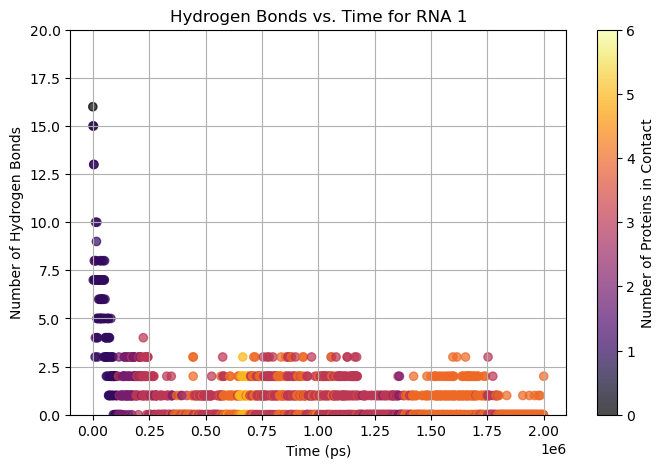

In [11]:
count_hbonds_rna(1, average_all=False, HbondType="GC")

/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, (resname GUA and (name N1 N2)) and (bynum 32409:33115), and Acceptor, (resname GUA and (name N7 O6)) and (bynum 32409:33115).
  warnings.warn(
/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, (resname GUA and (name N1 N2)) and (bynum 45842:46548), and Acceptor, (resname GUA and (name N7 O6)) and (bynum 45842:46548).
  warnings.warn(
/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, (resname GUA and (name N1 N2)) and (bynum 37358:38064), and Acceptor, (resname GUA and (name N7 O6)) and (bynum 37358:38064).
  warnings.warn(
/opt/conda/en

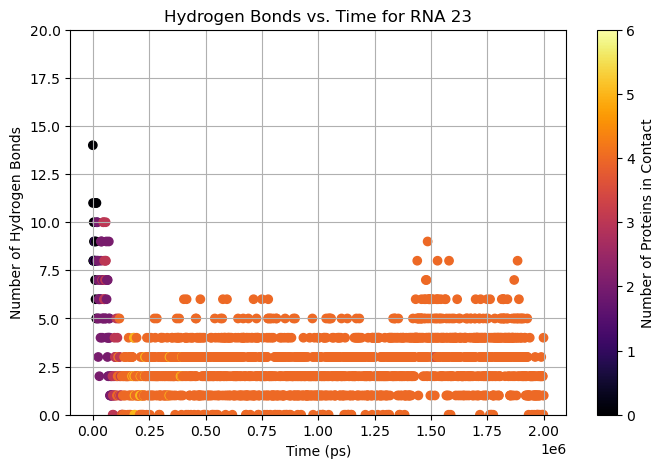

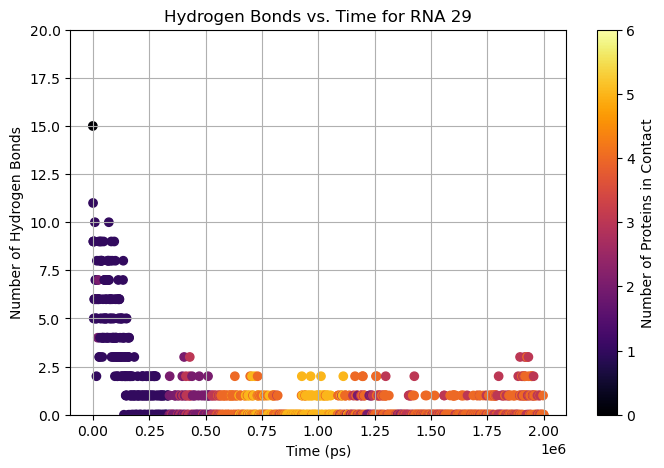

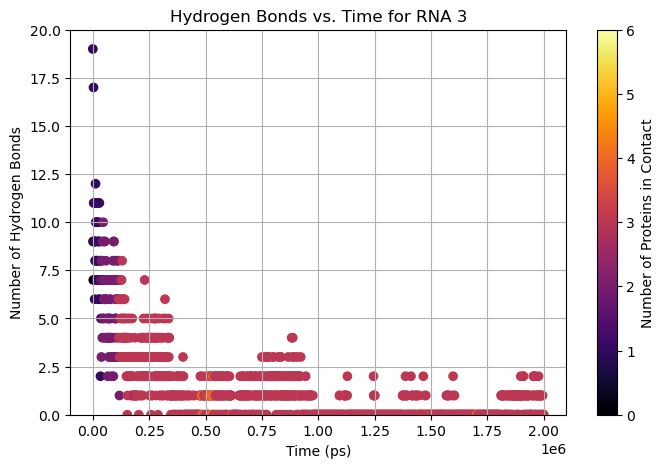

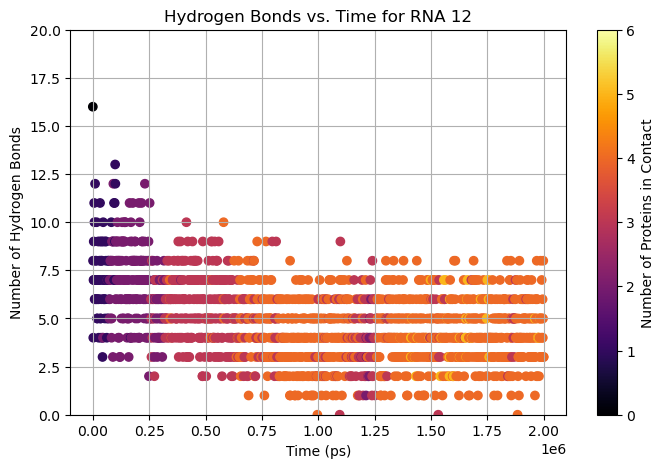

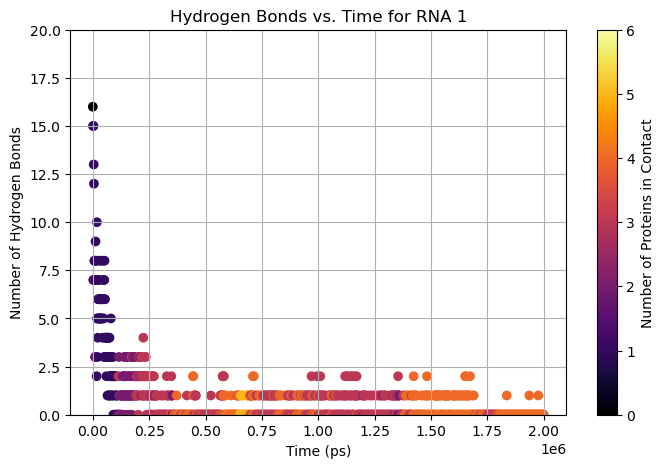

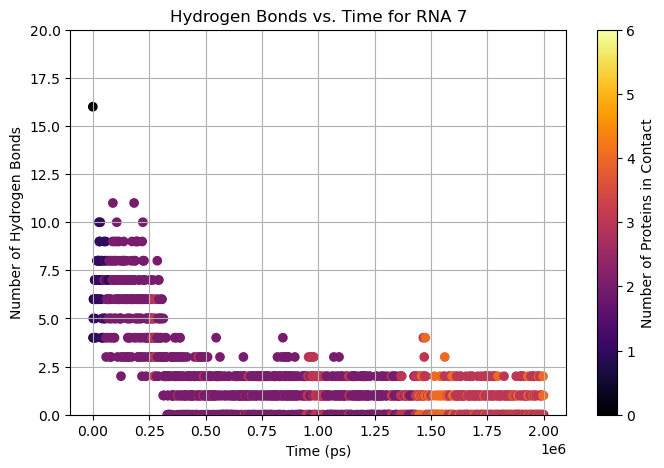

/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:774: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, (resname GUA and (name N1 N2)) and (bynum 42307:43013), and Acceptor, (resname GUA and (name N7 O6)) and (bynum 42307:43013).
  warnings.warn(


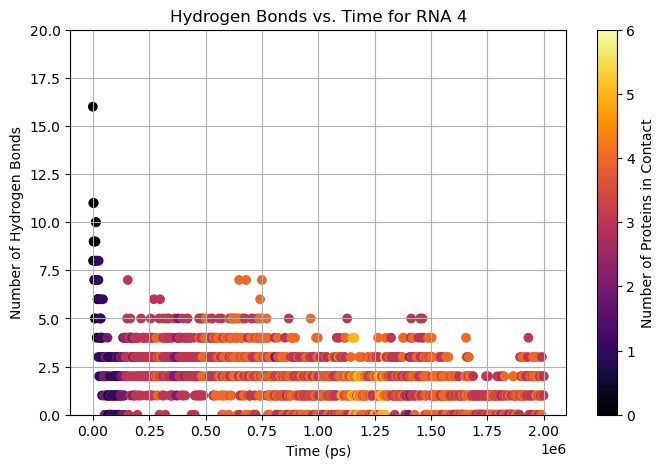

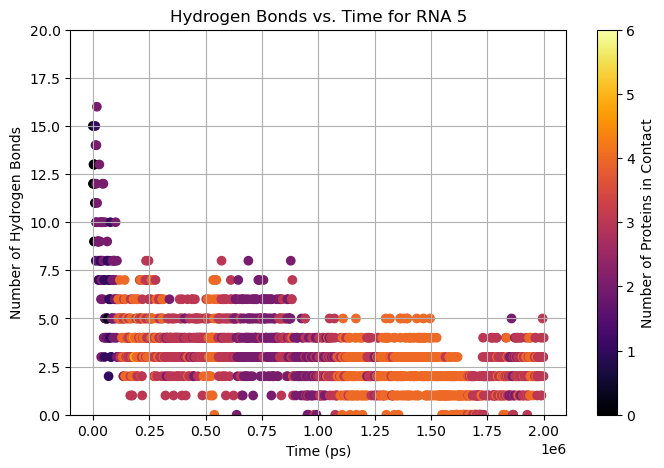

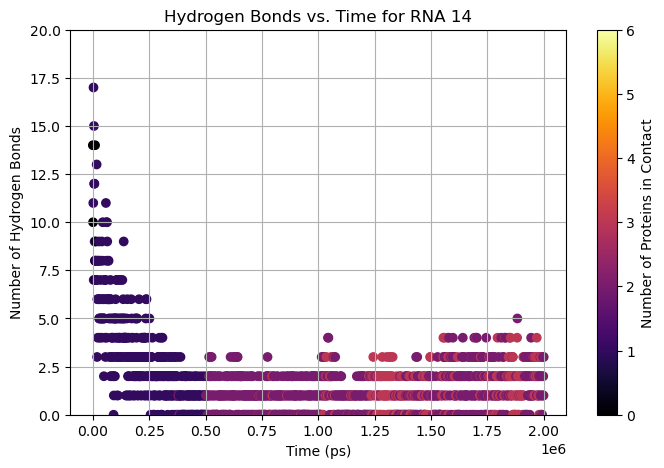

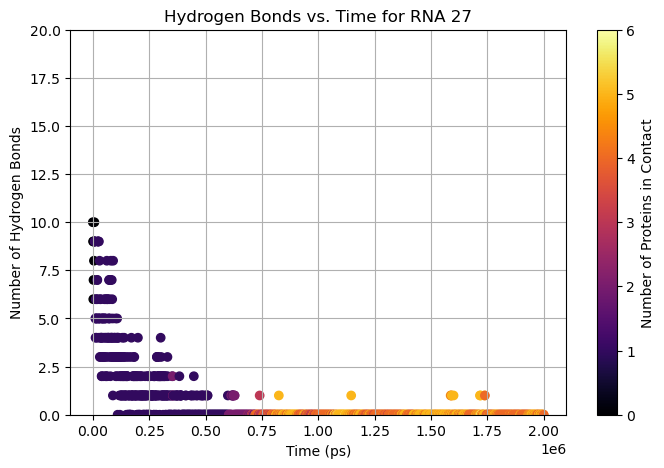

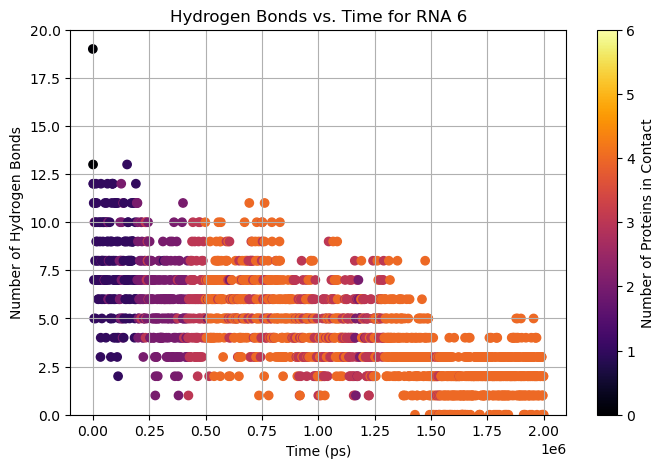

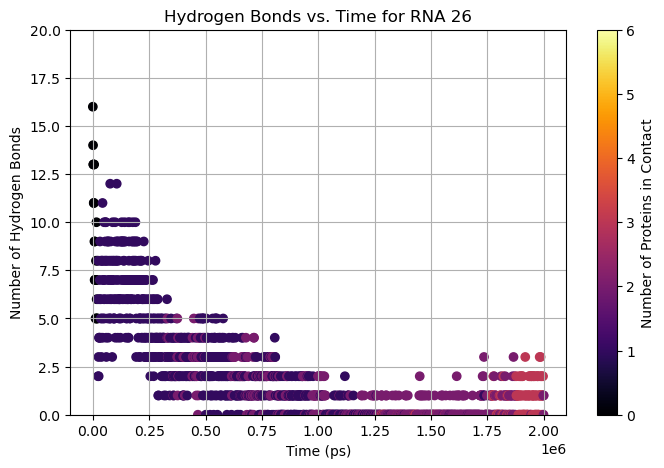

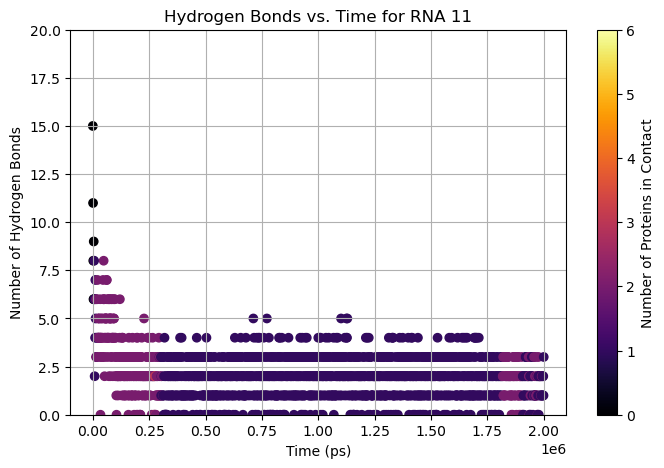

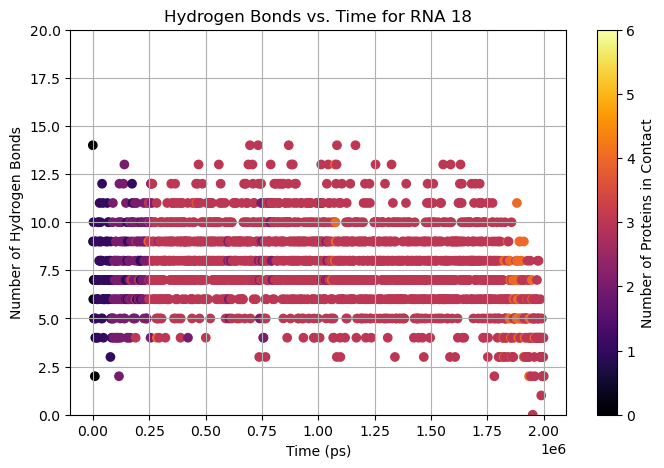

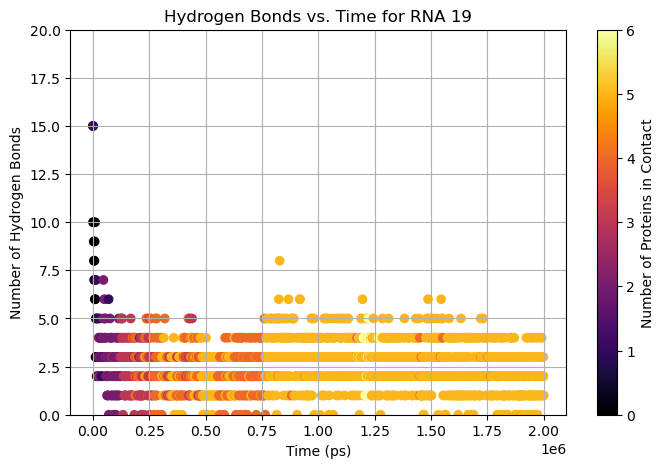

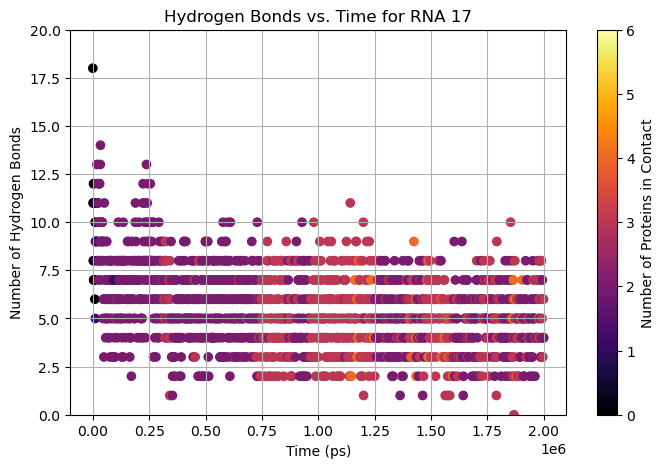

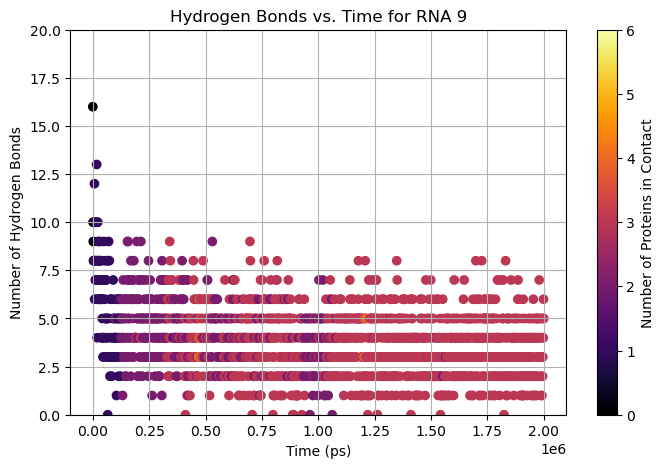

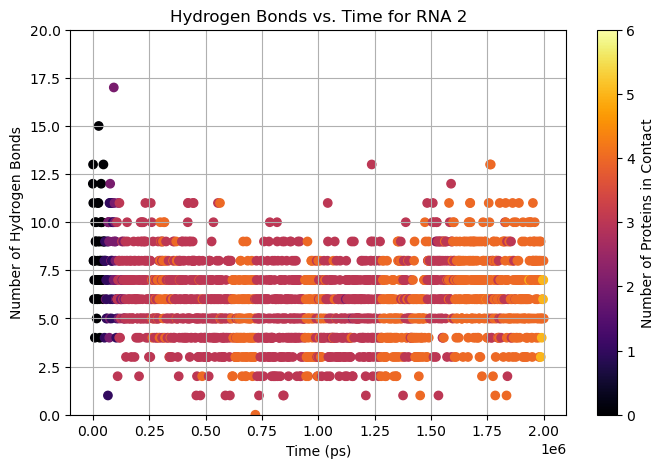

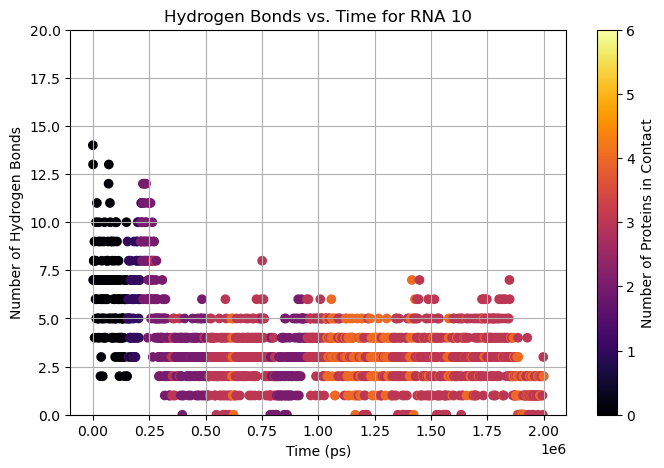

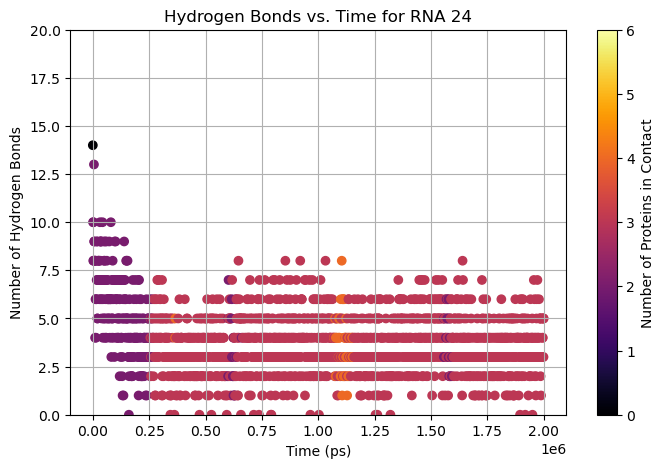

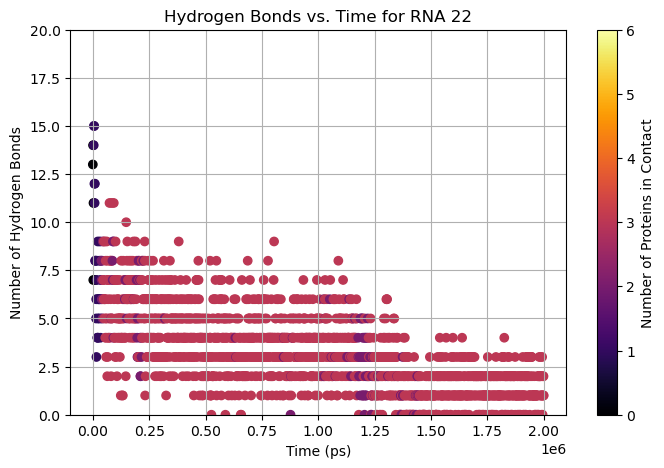

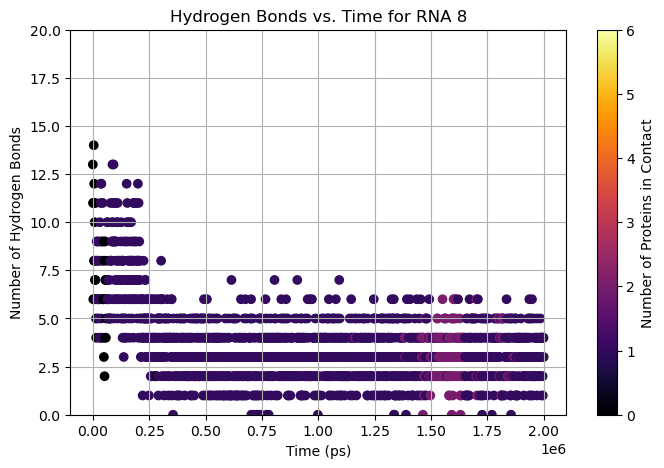

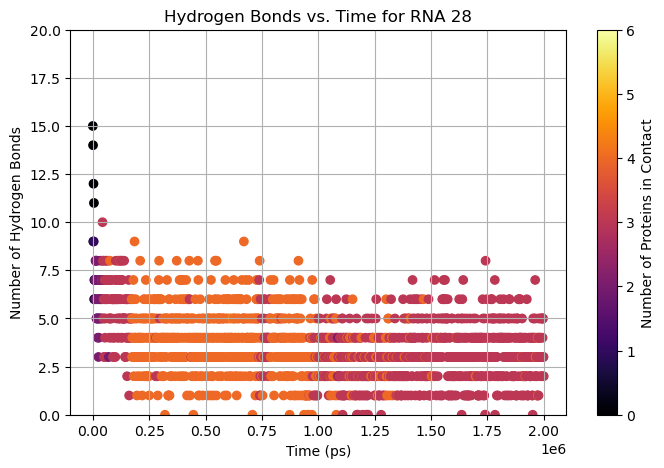

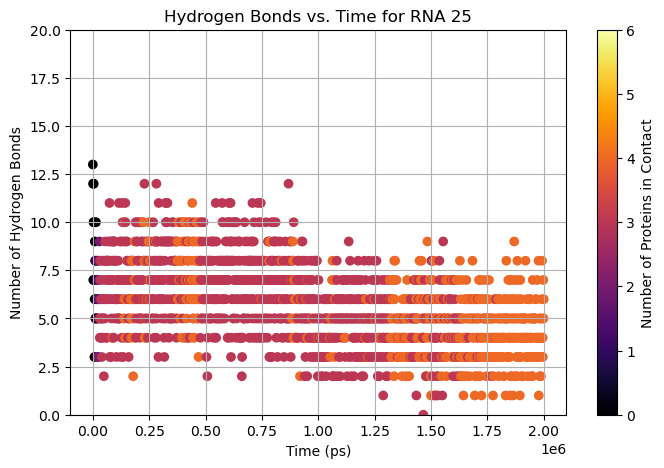

In [12]:
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor

def count_hbonds_rna_par(rna_index, gro_file, xtc_file):
    uni = mda.Universe(gro_file, xtc_file) # create its own universe
    index_min = rna_start + rna_index * RNA_LEN + 1
    index_max = rna_start + (rna_index + 1) * RNA_LEN
    donors_sel = f'(resname GUA and (name N1 N2)) and (bynum {index_min}:{index_max})'
    hydrogens_sel = f'(resname GUA and (name H1 H21 H22)) and (bynum {index_min}:{index_max})'
    acceptors_sel = f'(resname GUA and (name N7 O6)) and (bynum {index_min}:{index_max})'

    # Initialize the hydrogen bond analysis
    hbonds = HBA(
        universe=uni,
        donors_sel=donors_sel,
        hydrogens_sel=hydrogens_sel,
        acceptors_sel=acceptors_sel,
    )
    # get number of proteins in contact at each frame
    prot_in_contact = contacts_prot_rna_job_traj(gro_file, xtc_file, rna_index, radius=8)
    # Run the analysis
    hbonds.run(start=0, stop=len(prot_in_contact))
    hbond_counts = hbonds.count_by_time()
    time_steps = hbonds.times  # Get time steps


    # Create scatter plot with point colors based on number of proteins in contact
    plt.figure(figsize=(8, 5))
    sc = plt.scatter(time_steps, hbond_counts, c=prot_in_contact, cmap='inferno', marker='o', vmin=0, vmax=6)
    plt.xlabel('Time (ps)')
    plt.ylabel('Number of Hydrogen Bonds')
    plt.title(f'Hydrogen Bonds vs. Time for RNA {rna_index}')
    plt.grid(True)
    plt.colorbar(sc, label='Number of Proteins in Contact')
    plt.ylim(0, 20) #set the limit to 20
    plt.show()
    
    # or return something more useful
    return 1

with ProcessPoolExecutor(max_workers=32) as executor:
    futures = []
    ress = 0
    for i in range(NUM_RNA):
        futures.append(executor.submit(count_hbonds_rna_par, i, gro_file, xtc_file))
    
    for future in concurrent.futures.as_completed(futures):
        ress = ress + future.result()